## RaTG13 de-novo assembly - plots of assembled nucleotide sequences


Multiple preprints have questioned the validity of the metagenomic dataset upon which RaTG13 is based (Zhang, 2020; Rahalkar and Bahulikar, 2020; Singla et al., 2020; Signus, 2020). Here we undertook de-novo assembly of the metagenomic dataset uploaded by Zhou et al. (2020) to NCBI (SRA accession SRR11085797) using MEGAHIT (v.1.2.9) and CoronaSPAdes (v.3.15.0). We repeated the MEGAHIT assembly methodology of Singla et al. (2020), by utilising three settings: i) default; ii) maximum k-mer size set to 79; and iii) default settings with k-step=10 and --no-mercy option. For CoronaSPAdes, default settings were used. Each final assembly was then Blasted against the default nt dataset via NCBI. Consensus sequences from each of the assemblies are shown in Fig. 1 below. 16 contiguous sections of the 29855 nucleotide long RaTG13 sequence were not recovered during assembly of the SRA data by any of the methods used. This included 7 sequences of > 100 amino acids long, including a 48 amino acid long sequence in the NTD covering insert 3 identified by Zhou et al. (2020).

On the 19/5/2021, an amplicon dataset (accession SRR11806578) was uploaded to NCBI by Zhou et al, 2020, presumably in response to findings by Zhang (2020) and Singla et al. (2020). This dataset was also Blasted and results shown below.

1) [Blast2.ipynb](files/Blast2.ipynb) was run on the following assembiles

- final.contigs.fa MEGAHIT reults using default settings for NCBI accession SRR11085797
- final.contigs.fa MEGAHIT reults using max Kmer of K79 for NCBI accession SRR11085797
- final.contigs.fa MEGAHIT reults using k-step10 and --no-mercy option for NCBI accession SRR11085797
- gene_clusters.fasta CoronaSPAdes reults using default settings for NCBI accession SRR11085797
- SRR11806578.fa generated using Biopython from SRR11806578.fastq, sourced from NCBI accession SRR11085797

2) The results of consensus fastsa sequences generated in [Blast2.ipynb](files/Blast2.ipynb) were then used in this notebook.

The first 4 files in list above are SRA's uploaded to NCBI on 13/3/2021, the last file contains amplicon data uploaded to NCBI on the 19/5/2021

We agree with the findings of Zhang (2020) and Singla et al. (2020), in that RaTG13 cannot be assembled using the RaTG13 SRA dataset SRR11085797. Further, we find the full genome sequence still cannot be assembled when combined with the amplicon datsaset SRR11085797, as the first 14nt are missing from sequence matches in SRR11085797 and SRR11085797.

<img src="figures/5_RaTG13_SL3_R1_stiched_asm_seqs_amplicon.png">

Figure 1. Consensus nucleotide sequences of accession SRR11085797 generated using assembly with Megablast and CoronaSPAdes and Blasted using NCBI Blastn against MN996532.2 (first four dark blue rows), as well as Amplicon dataset NCBI accession SRR11806578 shown in bottom row. 

Nucleotide sequences with significant alignments to RaTG13 (MN996532.2) are shown in dark blue. Red shows areas of poor coverages (single nt hits surrounded by empty reads, yellow shows areas of very poor coverage). Note that several regions in the amplicon dataset show poor sequence coverage.

Structural subdomains of the RaTG13 genome shown at top of image.

In [1]:
import os
import collections
import re
import pathlib
from io import StringIO
from Bio import SeqIO
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from itertools import groupby

In [2]:
FASTA_PATH='../../fasta/'
TARGET_FILE='MN996532_2_RaTG13_complete_genome.fa'
ASM_PATH=FASTA_PATH+'asm_out/'
FASTA_LIST=['RaTG13_SL3_R1_megahit_default.fa', 'RaTG13_SL3_R1_megahit_k79.fa',\
            'RaTG13_SL3_R1_megahit_kstep10_nm.fa', 'RaTG13_SL3_R1_coronaspades_default.fa', \
            'RaTG13_SRR11806578_SRR11806578_amplicons.fa']
COV_NAME='RaTG13'
ASM_CODE='SL3_R1'
#specific to each genome, below are nt locations for major subdomain boundaries (ORF1ab etc) for RaTG13
#leave as empty list if not required
SUBDOMAIN_LOCATIONS=[266, 21563,22549,23311,23604,25360,25381,26208,26511,27179,28262,29521]
OUT_PATH=ASM_PATH+'comparison_plots/'
pathlib.Path(OUT_PATH).mkdir(exist_ok=True)

In [3]:
query_file = os.path.join(FASTA_PATH, TARGET_FILE)
fasta_files = [os.path.join(ASM_PATH, x) for x in FASTA_LIST]

In [4]:
query_target = SeqIO.read(query_file, format="fasta")
query_target_seq=query_target.seq

fasta_targets = [SeqIO.read(x, format="fasta") for x in fasta_files]
assert len(fasta_targets)==len(FASTA_LIST)

In [5]:
fasta_seqs=[str(x.seq) for x in fasta_targets]
fasta_titles=[x.description for x in fasta_targets]

In [6]:
for s in fasta_seqs:
    assert len(s)==len(query_target_seq)

In [7]:
def plot_blocked_seq(stack_arr, name='sequences_blocked.png', cmap='CMRmap_r', title=''):
    print(f'>>plot_blocked_seq, stack_arr: {stack_arr.shape}')
    fig= plt.figure(figsize=(20,6))
    plt.imshow(stack_arr, cmap=plt.get_cmap(cmap))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.xlabel('nucleotides', fontsize=10)
    plt.xticks(fontsize=10)
    plt.title(f'{title}', fontsize=12)
    plt.tight_layout()
    plt.savefig(name, dpi=600)
    plt.show()

In [8]:
def ord_convert(x):
    '''convert each character in array to its integer representation'''
    return ord(x)
ord_v = np.vectorize(ord_convert)

In [9]:
seq_arrays=[np.array(list(x)) for x in fasta_seqs]
ord_arrays=[]
for seqa in seq_arrays:
    ta=ord_v(seqa)
    #change '-' char value to zero for background colour
    ta[ta == 45] = 0
    ord_arrays.append(ta)

In [10]:
#add an empty array in between each for plotting
spacer_array=np.zeros(len(query_target_seq))
spaced_seqs=[]
for a in ord_arrays:
    spaced_seqs.append(a)
    spaced_seqs.append(spacer_array)

In [11]:
subdomain_boundaris= SUBDOMAIN_LOCATIONS
subdomain_array=np.zeros(len(query_target_seq))
for b in subdomain_boundaris:
    subdomain_array[b]= 84

In [12]:
twod_borders=np.stack([subdomain_array, subdomain_array], axis=0)
spacer_twod=np.stack([spacer_array, spacer_array], axis=0)
twod_borders=np.stack([twod_borders, spacer_twod], axis=0)

In [13]:
twod_borders=twod_borders.reshape(4, len(query_target_seq))
twod_borders.shape

(4, 29855)

In [14]:
twod_borders_repeated = np.repeat(twod_borders, repeats=500, axis=0)
twod_borders_repeated.shape

(2000, 29855)

In [15]:
#convert to 2D so can plot
stacked=np.stack(spaced_seqs, axis=0)

In [16]:
np.unique(stacked[0])

array([ 0., 65., 67., 71., 84.])

In [17]:
stacked_repeated = np.repeat(stacked, repeats=500, axis=0)
stacked_repeated.shape

(5000, 29855)

In [18]:
twod_borders_on_stack=np.vstack((twod_borders_repeated, stacked_repeated))
twod_borders_on_stack.shape

(7000, 29855)

>>plot_blocked_seq, stack_arr: (7000, 29855)


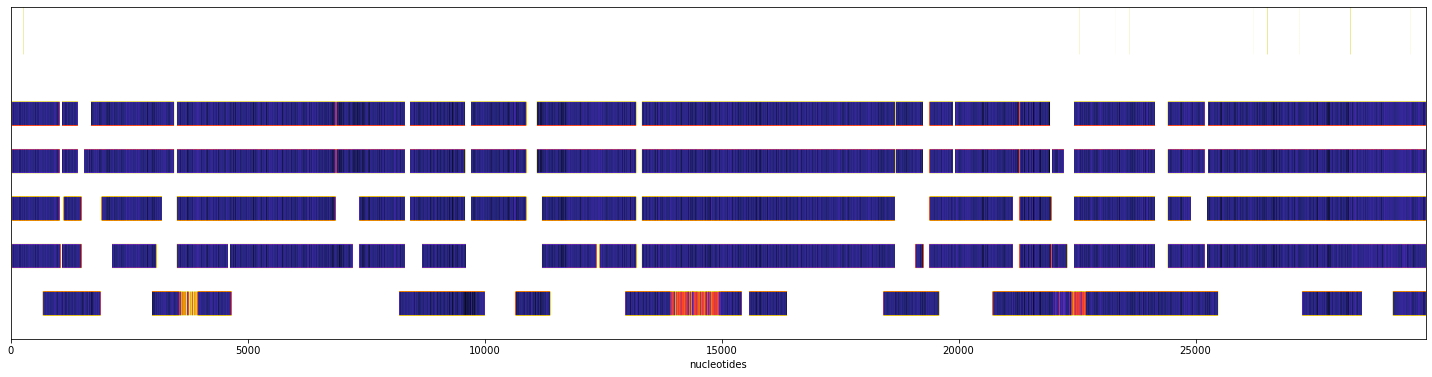

In [19]:
#if want a tile:
#plot_title=', '.join(x for x in FASTA_LIST)
plot_title=''
plot_blocked_seq(twod_borders_on_stack, name=OUT_PATH+f'{len(FASTA_LIST)}_{COV_NAME}_{ASM_CODE}_stiched_asm_seqs.png', title=plot_title)

Figure 2. (generation of Figure 1). In the figure above we can see 5 rows of nuclotide sequences. The first four rows shows consensus sequences from assembly of SRA dataset NCBI accession SRR11085797. There are multiple gaps in the dataset, and the RaTG13 sequence cannot be assembled from these alone.

The last row shows consensus sequences from assembly of Amplicon dataset NCBI accession SRR11806578 which covers most gaps, however the first 14nt are still not covered, as well as multiple single to triple nucleotide locations in the spike protein.

In [20]:
missing_nns = np.argwhere(np.all(stacked[..., :] == 0, axis=0)).tolist()

In [21]:
len(missing_nns)

40

In [22]:
missing_nns = [item for sublist in missing_nns for item in sublist]

In [23]:
#S protein location specific to RaTG13
spike_seq_missing = [i for i in missing_nns if int(i) >= 21563 and int(i)<=25384 ]

In [24]:
len(spike_seq_missing)

26

In [25]:
def group(L):
    '''after https://stackoverflow.com/questions/2154249/identify-groups-of-continuous-numbers-in-a-list'''''
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

In [26]:
print (list(group(spike_seq_missing)))

[(22326, 22326), (22333, 22333), (22369, 22370), (22374, 22374), (22378, 22378), (22384, 22384), (22386, 22386), (22389, 22389), (22394, 22394), (22396, 22396), (22399, 22400), (22402, 22402), (22405, 22405), (22407, 22407), (22411, 22411), (22414, 22416), (22418, 22418), (22420, 22421), (22423, 22423), (22425, 22425), (22427, 22427)]


In [27]:
grouped_missing= list(group(missing_nns))

The list below shows tuples of (start, end) of gaps in coverage accross all the fasta inputs

In [28]:
grouped_missing

[(0, 13),
 (22326, 22326),
 (22333, 22333),
 (22369, 22370),
 (22374, 22374),
 (22378, 22378),
 (22384, 22384),
 (22386, 22386),
 (22389, 22389),
 (22394, 22394),
 (22396, 22396),
 (22399, 22400),
 (22402, 22402),
 (22405, 22405),
 (22407, 22407),
 (22411, 22411),
 (22414, 22416),
 (22418, 22418),
 (22420, 22421),
 (22423, 22423),
 (22425, 22425),
 (22427, 22427)]

In [29]:
deltas=[]
for t in grouped_missing:
    deltas.append(1+t[1]-t[0])

In [30]:
#number of and legth of each gap (in NN)
len(deltas),deltas

(22, [14, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1])

<BarContainer object of 22 artists>

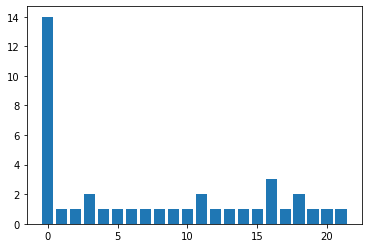

In [31]:
plt.bar(list(range(len(deltas))), deltas)

In [32]:
pct_missing = (len(missing_nns)/len(query_target_seq))%100

In [33]:
print(f'{pct_missing} from any assemby method')

0.001339809077206498 from any assemby method


### Summary

We can see there is no coverage of the first 14nt of RaTG13 from either of SRR11085797 or SRR11806578 as well as 21 single to triple nn locations in the spike protein. As such, RaTG13 could not have been assembled from the sequences provided by Zhou et al. (2020).

### References

Rahalkar, M.; Bahulikar, R. The Anomalous Nature of the Fecal Swab Data, Receptor Binding Domain and Other Questions in RaTG13 Genome . https://www.preprints.org/manuscript/202008.0205/v3 doi: 10.20944/preprints202008.0205.v3

Signus, J. Anomalous datasets reveal metagenomic fabrication pipeline that further questions the legitimacy of RaTG13 genome and the associated Nature paper. Preprint. https://vixra.org/abs/2010.0164

Singla, M., Ahmad, S., Gupta, C., Sethi, T. De-novo Assembly of RaTG13 Genome Reveals Inconsistencies Further Obscuring SARS-CoV-2 Origins. https://www.preprints.org/manuscript/202008.0595/v1 doi: 10.20944/preprints202008.0595.v1

Zhang, D. 2020. Anomalies in BatCoV/RaTG13 sequencing and provenance. Zenodo. http://doi.org/10.5281/zenodo.4064067 

Zhou, P., Yang, XL., Wang, XG. et al., 2020. A pneumonia outbreak associated with a new coronavirus of probable bat origin. Nature 579, 270–273 (2020). https://doi.org/10.1038/s41586-020-2012-7